In [1]:
#!/usr/bin/python
#import wradlib as wrl
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

import csv
import os
import datetime
import pandas as pd

#shapefile: GIS vector data format (ESRI)
import shapefile as shp  # Requires the pyshp package
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns
import shapely as shp
from shapely.geometry import Point
import shapely


import importlib
import geopandas as gpd
from matplotlib.patches import Rectangle
from collections import Counter

import _pickle as pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

#import external functions (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

In [2]:
#Folder address containing data:
fold = '/home/ciccuz/phd/KIT/hail_data/'

# Scripts to investigate IR Brightness temperature separating between hitted/missed large/small hail ESWD events

In [3]:
#Preliminar parameters:

#lat/lon coords to cover the whole SPHERA domain:
lonmin_S=6; lonmax_S=19; latmin_S=35; latmax_S=49
latplot_S=[latmin_S,latmax_S]; lonplot_S=[lonmin_S,lonmax_S]

#With geopandas: NEW VERSION!
sfg_ita = gpd.read_file(fold + "hail4_punge/geodata/ITA_adm/ITA_adm0.shp", encoding='latin-1')
sfg_deu = gpd.read_file(fold + "hail4_punge/geodata/DEU_adm/DEU_adm0.shp", encoding='latin-1')
sfg_aut = gpd.read_file(fold + "hail4_punge/geodata/AUT_adm/AUT_adm0.shp", encoding='latin-1')
sfg_che = gpd.read_file(fold + "hail4_punge/geodata/CHE_adm/CHE_adm0.shp", encoding='latin-1')
sfg_cro = gpd.read_file(fold + "hail4_punge/geodata/Croatia/mj788hg8036.shp", encoding='latin-1')
sfg_slo = gpd.read_file(fold + "hail4_punge/geodata/Slovenia/gk259nt7452.shp", encoding='latin-1')
sfg_hun = gpd.read_file(fold + "hail4_punge/geodata/Hungary/qh513vs8921.shp", encoding='latin-1')
sfg_alg = gpd.read_file(fold + "hail4_punge/geodata/algeria/rt767cn2098.shp", encoding='latin-1')
sfg_tun = gpd.read_file(fold + "hail4_punge/geodata/tunisia/TUN_adm0.shp", encoding='latin-1')
sfg_bos = gpd.read_file(fold + "hail4_punge/geodata/bosnia/bt512fj0408.shp", encoding='latin-1')
sfg_fra = gpd.read_file(fold + "hail4_punge/geodata/france/dw125xh0996.shp", encoding='latin-1')
sfg_mon = gpd.read_file(fold + "hail4_punge/geodata/montenegro/MNE_adm0.shp", encoding='latin-1')
sfg_cze = gpd.read_file(fold + "hail4_punge/geodata/czech/CZE_adm0.shp", encoding='latin-1')
sfg_svk = gpd.read_file(fold + "hail4_punge/geodata/slovakia/SVK_adm0.shp", encoding='latin-1')

#read shapefile of SPHERA 10km grid:
sf_sp = gpd.read_file(fold + "data/lampinet/mask/grid_10_49N.shp", encoding='latin-1')

sfg_land = gpd.read_file(fold + "hail4_punge/geodata/Land/ne_10m_land.shp", encoding='latin-1')

#maps limits whole SPHERA domain
x_lim_S=lonplot_S
y_lim_S=latplot_S

x_lim = x_lim_S
y_lim = y_lim_S

clonsel, clatsel, csizesel, cnamesel, ckindsel = HF.HF_cities(latmin_S,latmax_S,lonmin_S,lonmax_S)

#shapefile in vector form for considering multiple geographic shapefiles
sf_geo = [sfg_ita, sfg_aut, sfg_deu, sfg_che, sfg_cro, sfg_slo, sfg_hun, sfg_alg, sfg_tun, sfg_fra, sfg_bos,
          sfg_mon, sfg_cze, sfg_svk]

In [4]:
df_eswd = pd.read_csv(fold + 'hail4_punge/ESWD/ESWD_HAIL_19790101-20200531_v1_6.csv')   #Swabian Jura 2013

eswd_df = pd.DataFrame(columns=['datetime','lat','lon','size','QC_level'])
eswd_df['datetime'] = pd.to_datetime(df_eswd['TIME_EVENT'])
eswd_df['lat'] = df_eswd['LATITUDE']
eswd_df['lon'] = df_eswd['LONGITUDE']
eswd_df['size'] = df_eswd['MAX_HAIL_DIAMETER']
eswd_df['QC_level'] = df_eswd['QC_LEVEL']
eswd_df['Time_accuracy'] = df_eswd['TIME_ACCURACY']
eswd_df['Max_hailst_weight'] = df_eswd['MAX_HAILSTONE_WEIGHT']
eswd_df['Thickness_hail_layer'] = df_eswd['THICKNESS_HAIL_LAYER']
eswd_df['Total_damage'] = df_eswd['TOTAL_DAMAGE']
eswd_df['N_injured'] = df_eswd['NO_INJURED']
eswd_df['N_killed'] = df_eswd['NO_KILLED']
eswd_df['Impacts'] = df_eswd['IMPACTS']

eswd_df = eswd_df.sort_values(by='datetime').reset_index(drop=True)

#try:retain only data in the selected day and year and within hhmin and hhmax, as well as within latmin,latmax and lonmin,lonmax
eswd_df_years = eswd_df.datetime.apply(lambda x: x.year)
eswd_df_months = eswd_df.datetime.apply(lambda x: x.month)
eswd_df_days = eswd_df.datetime.apply(lambda x: x.day)
eswd_df_hours = eswd_df.datetime.apply(lambda x: x.hour)

eswd_df_sel = eswd_df.loc[(eswd_df_years >= 2016) & (eswd_df_years <= 2018) & (eswd_df_months >= 4)   #(eswd_df_years >= 1995) &
                         & (eswd_df_months <= 10)]
eswd_df_sel = eswd_df_sel.loc[(eswd_df_sel.lat >= latmin_S) & (eswd_df_sel.lat <= latmax_S)]
eswd_ev_sel = eswd_df_sel.loc[(eswd_df_sel.lon >= lonmin_S) & (eswd_df_sel.lon <= lonmax_S)].reset_index(drop=True)

#geodataframe:
eswd = gpd.GeoDataFrame(eswd_ev_sel, geometry=gpd.points_from_xy(eswd_ev_sel.lon, eswd_ev_sel.lat))

#remove data too close to sphera border!!:
L = [128,316,327,328,330,507,632,883,884,929]
eswd = eswd.drop(L)

#split eswd dataset in the years:
eswd_2016 = eswd[eswd.datetime.dt.year ==2016]
eswd_2017 = eswd[eswd.datetime.dt.year ==2017]
eswd_2018 = eswd[eswd.datetime.dt.year ==2018]

In [5]:
#LIST OF DAYS WITH JULIAN DAY AND DATETIME FORMAT FOR OT DATA:

#days in 2016: 214 days (actually 211 because the following days are missing: 2016185,2016186,2016201 )
days_2016 = [2016092,2016093,2016094,2016095,2016096,2016097,2016098,2016099,2016100,2016101,2016102,2016103,2016104,
        2016105,2016106,2016107,2016108,2016109,2016110,2016111,2016112,2016113,2016114,2016115,2016116,2016117,
        2016118,2016119,2016120,2016121,2016122,2016123,2016124,2016125,2016126,2016127,2016128,2016129,2016130,
        2016131,2016132,2016133,2016134,2016135,2016136,2016137,2016138,2016139,2016140,2016141,2016142,2016143,
        2016144,2016145,2016146,2016147,2016148,2016149,2016150,2016151,2016152,2016153,2016154,2016155,2016156,
        2016157,2016158,2016159,2016160,2016161,2016162,2016163,2016164,2016165,2016166,2016167,2016168,2016169,
        2016170,2016171,2016172,2016173,2016174,2016175,2016176,2016177,2016178,2016179,2016180,2016181,2016182,
        2016183,2016184,2016185,2016186,2016187,2016188,2016189,2016190,2016191,2016192,2016193,2016194,2016195,
        2016196,2016197,2016198,2016199,2016200,2016201,2016202,2016203,2016204,2016205,2016206,2016207,2016208,
        2016209,2016210,2016211,2016212,2016213,2016214,2016215,2016216,2016217,2016218,2016219,2016220,2016221,
        2016222,2016223,2016224,2016225,2016226,2016227,2016228,2016229,2016230,2016231,2016232,2016233,2016234,
        2016235,2016236,2016237,2016238,2016239,2016240,2016241,2016242,2016243,2016244,2016245,2016246,2016247,
        2016248,2016249,2016250,2016251,2016252,2016253,2016254,2016255,2016256,2016257,2016258,2016259,2016260,
        2016261,2016262,2016263,2016264,2016265,2016266,2016267,2016268,2016269,2016270,2016271,2016272,2016273,
        2016274,2016275,2016276,2016277,2016278,2016279,2016280,2016281,2016282,2016283,2016284,2016285,2016286,
        2016287,2016288,2016289,2016290,2016291,2016292,2016293,2016294,2016295,2016296,2016297,2016298,2016299,
        2016300,2016301,2016302,2016303,2016304,2016305]

#days in 2017: missing 1 april (2017091), 213 days
days_2017 = [2017091,2017092,2017093,2017094,2017095,2017096,2017097,2017098,2017099,2017100,2017101,2017102,2017103,2017104,
        2017105,2017106,2017107,2017108,2017109,2017110,2017111,2017112,2017113,2017114,2017115,2017116,2017117,
        2017118,2017119,2017120,2017121,2017122,2017123,2017124,2017125,2017126,2017127,2017128,2017129,2017130,
        2017131,2017132,2017133,2017134,2017135,2017136,2017137,2017138,2017139,2017140,2017141,2017142,2017143,
        2017144,2017145,2017146,2017147,2017148,2017149,2017150,2017151,2017152,2017153,2017154,2017155,2017156,
        2017157,2017158,2017159,2017160,2017161,2017162,2017163,2017164,2017165,2017166,2017167,2017168,2017169,
        2017170,2017171,2017172,2017173,2017174,2017175,2017176,2017177,2017178,2017179,2017180,2017181,2017182,
        2017183,2017184,2017185,2017186,2017187,2017188,2017189,2017190,2017191,2017192,2017193,2017194,2017195,
        2017196,2017197,2017198,2017199,2017200,2017201,2017202,2017203,2017204,2017205,2017206,2017207,2017208,
        2017209,2017210,2017211,2017212,2017213,2017214,2017215,2017216,2017217,2017218,2017219,2017220,2017221,
        2017222,2017223,2017224,2017225,2017226,2017227,2017228,2017229,2017230,2017231,2017232,2017233,2017234,
        2017235,2017236,2017237,2017238,2017239,2017240,2017241,2017242,2017243,2017244,2017245,2017246,2017247,
        2017248,2017249,2017250,2017251,2017252,2017253,2017254,2017255,2017256,2017257,2017258,2017259,2017260,
        2017261,2017262,2017263,2017264,2017265,2017266,2017267,2017268,2017269,2017270,2017271,2017272,2017273,
        2017274,2017275,2017276,2017277,2017278,2017279,2017280,2017281,2017282,2017283,2017284,2017285,2017286,
        2017287,2017288,2017289,2017290,2017291,2017292,2017293,2017294,2017295,2017296,2017297,2017298,2017299,
        2017300,2017301,2017302,2017303,2017304]

#days in 2018: missing 1 april (2018091) and 17 june (2018168), 212 days
days_2018 = [2018091,2018092,2018093,2018094,2018095,2018096,2018097,2018098,2018099,2018100,2018101,2018102,2018103,2018104,
        2018105,2018106,2018107,2018108,2018109,2018110,2018111,2018112,2018113,2018114,2018115,2018116,2018117,
        2018118,2018119,2018120,2018121,2018122,2018123,2018124,2018125,2018126,2018127,2018128,2018129,2018130,
        2018131,2018132,2018133,2018134,2018135,2018136,2018137,2018138,2018139,2018140,2018141,2018142,2018143,
        2018144,2018145,2018146,2018147,2018148,2018149,2018150,2018151,2018152,2018153,2018154,2018155,2018156,
        2018157,2018158,2018159,2018160,2018161,2018162,2018163,2018164,2018165,2018166,2018167,2018168,2018169,
        2018170,2018171,2018172,2018173,2018174,2018175,2018176,2018177,2018178,2018179,2018180,2018181,2018182,
        2018183,2018184,2018185,2018186,2018187,2018188,2018189,2018190,2018191,2018192,2018193,2018194,2018195,
        2018196,2018197,2018198,2018199,2018200,2018201,2018202,2018203,2018204,2018205,2018206,2018207,2018208,
        2018209,2018210,2018211,2018212,2018213,2018214,2018215,2018216,2018217,2018218,2018219,2018220,2018221,
        2018222,2018223,2018224,2018225,2018226,2018227,2018228,2018229,2018230,2018231,2018232,2018233,2018234,
        2018235,2018236,2018237,2018238,2018239,2018240,2018241,2018242,2018243,2018244,2018245,2018246,2018247,
        2018248,2018249,2018250,2018251,2018252,2018253,2018254,2018255,2018256,2018257,2018258,2018259,2018260,
        2018261,2018262,2018263,2018264,2018265,2018266,2018267,2018268,2018269,2018270,2018271,2018272,2018273,
        2018274,2018275,2018276,2018277,2018278,2018279,2018280,2018281,2018282,2018283,2018284,2018285,2018286,
        2018287,2018288,2018289,2018290,2018291,2018292,2018293,2018294,2018295,2018296,2018297,2018298,2018299,
        2018300,2018301,2018302,2018303,2018304]

#write dataframes storing julian days and datetimes of OT days:
days_2016_df =pd.DataFrame(index=np.arange(0,len(days_2016),1), columns=['day','dtime'])
days_2017_df =pd.DataFrame(index=np.arange(0,len(days_2017),1), columns=['day','dtime'])
days_2018_df =pd.DataFrame(index=np.arange(0,len(days_2018),1), columns=['day','dtime'])

for day,ind in zip(days_2016,np.arange(0,len(days_2016),1)):
    
    dtime = datetime.datetime.strptime('2016-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2016_df.iloc[ind]['day'] = day
    days_2016_df.iloc[ind]['dtime'] = dtime    

for day,ind in zip(days_2017,np.arange(0,len(days_2017),1)):
    
    dtime = datetime.datetime.strptime('2017-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2017_df.iloc[ind]['day'] = day
    days_2017_df.iloc[ind]['dtime'] = dtime    
    
for day,ind in zip(days_2018,np.arange(0,len(days_2018),1)):
    
    dtime = datetime.datetime.strptime('2018-04-01','%Y-%m-%d') + timedelta(days=int(ind)) 
    
    days_2018_df.iloc[ind]['day'] = day
    days_2018_df.iloc[ind]['dtime'] = dtime
    
days_2016_df.dtime = pd.to_datetime(days_2016_df.dtime)
days_2017_df.dtime = pd.to_datetime(days_2017_df.dtime)
days_2018_df.dtime = pd.to_datetime(days_2018_df.dtime)

#REMOVE MISSING DAYS (after creating dataframes otherwise day and dtime are shifted and wrong!!!)

#-2016: 2016185,2016186,2016201
days_2016_df = days_2016_df[(days_2016_df.day !=2016185) & (days_2016_df.day !=2016186) & 
                            (days_2016_df.day !=2016201)]
#-2017: 2017091 
days_2017_df = days_2017_df[days_2017_df.day != 2017091]

#-2018: 2018091, 2018168
days_2018_df = days_2018_df[(days_2018_df.day != 2018091) & (days_2018_df.day != 2018093) & (days_2018_df.day != 2018168)]

### - Separate hitted/missed eswd events and extract OTs around each event:

In [6]:
#UPLOAD ESWD DATA AFTER FILTERING:

with open(fold + 'data/OTfilter_validation/2016/valid_vs_eswd/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2016 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/2017/valid_vs_eswd/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2017 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/2018/valid_vs_eswd/filtOTset_vs_eswd.txt', 'rb') as file:
     filtOTset_valid_eswd_2018 = pickle.load(file)

In [7]:
#FILTERED OTs HITTED ESWD REPORTS
filt_eswd_HITTED_2016 = filtOTset_valid_eswd_2016['reports_HITTED_uniq']
filt_eswd_HITTED_2017 = filtOTset_valid_eswd_2017['reports_HITTED_uniq']
filt_eswd_HITTED_2018 = filtOTset_valid_eswd_2018['reports_HITTED_uniq']

filt_eswd_HITTED_2016_2018 = pd.concat([filt_eswd_HITTED_2016,filt_eswd_HITTED_2017,filt_eswd_HITTED_2018])

#FILTERED OTs MISSED ESWD REPORTS
filt_eswd_MISSED_2016_2018 = eswd[~eswd.index.isin(filt_eswd_HITTED_2016_2018.index)]

filt_eswd_MISSED_2016 = filt_eswd_MISSED_2016_2018[filt_eswd_MISSED_2016_2018.datetime.dt.year == 2016]
filt_eswd_MISSED_2017 = filt_eswd_MISSED_2016_2018[filt_eswd_MISSED_2016_2018.datetime.dt.year == 2017]
filt_eswd_MISSED_2018 = filt_eswd_MISSED_2016_2018[filt_eswd_MISSED_2016_2018.datetime.dt.year == 2018]

filt_eswd_MISSED_2016_2018 = pd.concat([filt_eswd_MISSED_2016,filt_eswd_MISSED_2017,filt_eswd_MISSED_2018])


In [8]:
#SEPARATE BETWEEN LARGE/SMALL HAIL IN HITTED ESWD REPORTS
filt_eswd_HITTED_2016_small = filt_eswd_HITTED_2016[filt_eswd_HITTED_2016['size']<3]
filt_eswd_HITTED_2016_large = filt_eswd_HITTED_2016[filt_eswd_HITTED_2016['size']>=3]

filt_eswd_HITTED_2017_small = filt_eswd_HITTED_2017[filt_eswd_HITTED_2017['size']<3]
filt_eswd_HITTED_2017_large = filt_eswd_HITTED_2017[filt_eswd_HITTED_2017['size']>=3]

filt_eswd_HITTED_2018_small = filt_eswd_HITTED_2018[filt_eswd_HITTED_2018['size']<3]
filt_eswd_HITTED_2018_large = filt_eswd_HITTED_2018[filt_eswd_HITTED_2018['size']>=3]

#SEPARATE FURTHER FOR VERY LARGE HAIL (>=5CM)
filt_eswd_HITTED_2016_Verylarge = filt_eswd_HITTED_2016[filt_eswd_HITTED_2016['size']>=5]
filt_eswd_HITTED_2017_Verylarge = filt_eswd_HITTED_2017[filt_eswd_HITTED_2017['size']>=5]
filt_eswd_HITTED_2018_Verylarge = filt_eswd_HITTED_2018[filt_eswd_HITTED_2018['size']>=5]

In [9]:
#SEPARATE BETWEEN LARGE/SMALL HAIL IN MISSED ESWD REPORTS
filt_eswd_MISSED_2016_small = filt_eswd_MISSED_2016[filt_eswd_MISSED_2016['size']<3]
filt_eswd_MISSED_2016_large = filt_eswd_MISSED_2016[filt_eswd_MISSED_2016['size']>=3]

filt_eswd_MISSED_2017_small = filt_eswd_MISSED_2017[filt_eswd_MISSED_2017['size']<3]
filt_eswd_MISSED_2017_large = filt_eswd_MISSED_2017[filt_eswd_MISSED_2017['size']>=3]

filt_eswd_MISSED_2018_small = filt_eswd_MISSED_2018[filt_eswd_MISSED_2018['size']<3]
filt_eswd_MISSED_2018_large = filt_eswd_MISSED_2018[filt_eswd_MISSED_2018['size']>=3]

#SEPARATE FURTHER FOR VERY LARGE HAIL (>=5CM)
filt_eswd_MISSED_2016_Verylarge = filt_eswd_MISSED_2016[filt_eswd_MISSED_2016['size']>=5]
filt_eswd_MISSED_2017_Verylarge = filt_eswd_MISSED_2017[filt_eswd_MISSED_2017['size']>=5]
filt_eswd_MISSED_2018_Verylarge = filt_eswd_MISSED_2018[filt_eswd_MISSED_2018['size']>=5]

In [10]:
#Find out the days containing at least 1 ESWD missed event
day_2016_wMissed_evs_df = days_2016_df[days_2016_df.dtime.isin(filt_eswd_MISSED_2016.datetime.dt.strftime("%Y-%m-%d"))]
day_2017_wMissed_evs_df = days_2017_df[days_2017_df.dtime.isin(filt_eswd_MISSED_2017.datetime.dt.strftime("%Y-%m-%d"))]
day_2018_wMissed_evs_df = days_2018_df[days_2018_df.dtime.isin(filt_eswd_MISSED_2018.datetime.dt.strftime("%Y-%m-%d"))]

### - Upload original OTs dataset (with otpmax >0.5) to find out irbmin around each eswd HITTED report

In [34]:
OT_2016 = dict()

for d_ind in days_2016_df.index:
    
    day = days_2016_df['day'][d_ind]
    dtime = days_2016_df['dtime'][d_ind]
    
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_05/{dtime.year}/OT_{day}.txt', "rb") as file:  
         OT_dict = pickle.load(file)
            
    OT_2016[day] = OT_dict

In [81]:
OT_2017 = dict()

for d_ind in days_2017_df.index:
    
    day = days_2017_df['day'][d_ind]
    dtime = days_2017_df['dtime'][d_ind]
    
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_05/{dtime.year}/OT_{day}.txt', "rb") as file:  
         OT_dict = pickle.load(file)
            
    OT_2017[day] = OT_dict

In [85]:
OT_2018 = dict()

for d_ind in days_2018_df.index:
    
    day = days_2018_df['day'][d_ind]
    dtime = days_2018_df['dtime'][d_ind]
    
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_05/{dtime.year}/OT_{day}.txt', "rb") as file:  
         OT_dict = pickle.load(file)
            
    OT_2018[day] = OT_dict

In [37]:
#extract the full sets of all OTs and filtered OTs considering the whole sample of events
all_OTset_2016 = gpd.GeoDataFrame(columns=['lon', 'lat', 'time', 'otpmax', 'geometry'])

for d_ind in days_2016_df.index:
    
    day = days_2016_df['day'][d_ind]
    
    OTday_hours = OT_2016[day].keys()
    
    for hour in OTday_hours:
        
        all_OTset_2016 = all_OTset_2016.append(OT_2016[day][hour].reset_index(drop=True))

all_OTset_2016 = all_OTset_2016.reset_index(drop=True)

#select OTs only over LAND:
all_OTset_2016_land = gpd.clip(all_OTset_2016, sfg_land).sort_index()

#convert time column to datetime format (dont know why its not kept from before!!)
all_OTset_2016_land.time = pd.to_datetime(all_OTset_2016_land.time)

In [86]:
#extract the full sets of all OTs and filtered OTs considering the whole sample of events
all_OTset_2017 = gpd.GeoDataFrame(columns=['lon', 'lat', 'time', 'otpmax', 'geometry'])

for d_ind in days_2017_df.index:
    
    day = days_2017_df['day'][d_ind]
    
    OTday_hours = OT_2017[day].keys()
    
    for hour in OTday_hours:
        
        all_OTset_2017 = all_OTset_2017.append(OT_2017[day][hour].reset_index(drop=True))

all_OTset_2017 = all_OTset_2017.reset_index(drop=True)

#select OTs only over LAND:
all_OTset_2017_land = gpd.clip(all_OTset_2017, sfg_land).sort_index()

#convert time column to datetime format (dont know why its not kept from before!!)
all_OTset_2017_land.time = pd.to_datetime(all_OTset_2017_land.time)

In [87]:
#extract the full sets of all OTs and filtered OTs considering the whole sample of events
all_OTset_2018 = gpd.GeoDataFrame(columns=['lon', 'lat', 'time', 'otpmax', 'geometry'])

for d_ind in days_2018_df.index:
    
    day = days_2018_df['day'][d_ind]
    
    OTday_hours = OT_2018[day].keys()
    
    for hour in OTday_hours:
        
        all_OTset_2018 = all_OTset_2018.append(OT_2018[day][hour].reset_index(drop=True))

all_OTset_2018 = all_OTset_2018.reset_index(drop=True)

#select OTs only over LAND:
all_OTset_2018_land = gpd.clip(all_OTset_2018, sfg_land).sort_index()

#convert time column to datetime format (dont know why its not kept from before!!)
all_OTset_2018_land.time = pd.to_datetime(all_OTset_2018_land.time)

In [12]:
#define dimension of the cell: 0.23° approx 25km boxes
cell_size = 0.23

In [ ]:
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2016_land.lon, all_OTset_2016_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shapely.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2016_land['geometry_25km_box'] = cell.values

In [96]:
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2017_land.lon, all_OTset_2017_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shapely.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2017_land['geometry_25km_box'] = cell.values

In [97]:
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(all_OTset_2018_land.lon, all_OTset_2018_land.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shapely.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
all_OTset_2018_land['geometry_25km_box'] = cell.values

### - Upload original OTs dataset (with any otpmax also <0.5) to find out irbmin around each eswd MISSED report

OT_2016_missed_allOpt = dict()

for d_ind in day_2016_wMissed_evs_df.index:
    
    day = day_2016_wMissed_evs_df['day'][d_ind]
    dtime = day_2016_wMissed_evs_df['dtime'][d_ind]
    
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_all_onlyMISSEDeswd/{dtime.year}/OT_{day}.txt', "rb") as file:  
         OT_dict = pickle.load(file)
            
    OT_2016_missed_allOpt[day] = OT_dict

<span style="color:red">**NOT POSSIBLE** to upload data in this way (Kernel crashes) because now we have so much data compared to before: the whole OT grid of 3km is present 4 times (one every 15 min) for each hour, i.e. 142688 data every hour!</span>.

We need to upload every single (MISSED events) day singularly and proceed in the identification of nearby eswd OTs

In [11]:
day_2016_wMissed_evs_df

,day,dtime
5,2016097,2016-04-06
6,2016098,2016-04-07
7,2016099,2016-04-08
11,2016103,2016-04-12
12,2016104,2016-04-13
13,2016105,2016-04-14
18,2016110,2016-04-19
30,2016122,2016-05-01
32,2016124,2016-05-03
33,2016125,2016-05-04


(12.0, 14.0)

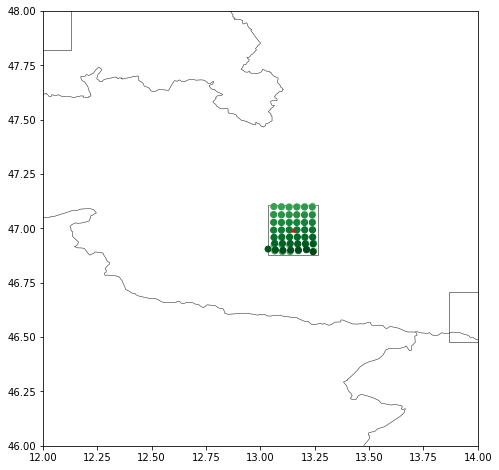

In [116]:
ax = eswdSET[:1].plot(markersize=10, figsize=(12, 8), marker='^', color='red',zorder=2)


ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
#plt.autoscale(False)

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)

gpd.GeoDataFrame(eswdSET['geometry_25km_box'], columns=['geometry_25km_box']).rename(columns={'geometry_25km_box' : 'geometry'}).plot(ax=ax, facecolor="none", edgecolor='grey');
gpd.GeoDataFrame(OT_3h_eswd25km['geometry']).plot(ax=ax,cmap='Greens')

ax.set_ylim([46,48])
ax.set_xlim([12,14])

Facendo il procedimento come sotto (ciclo sulle ore e ciclo sui OTset per ogni ora con 142688 dati per ogni ora) diventa un procedimento infinito... Conviene estrarre gli OT alle ore in un intorno temporale di ogni ESWD report e fare il processo su quel subset di OT data

**DA FARE!!**

In [13]:
eswdSET = filt_eswd_MISSED_2018

#ADD 25KM BOX GEOMETRY AROUND EACH ESWD REPORT!
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(eswdSET.lon, eswdSET.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shapely.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
eswdSET['geometry_25km_box'] = cell.values

In [14]:
#Read dataframe from external file
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2018.txt', 'rb') as file:
     OTs_aroundMissed_eswd = pickle.load(file)

In [25]:
eswd_ind = 1347
eswdRep = eswdSET.loc[eswd_ind]
eswdTime = eswdRep['datetime']

In [27]:
#extract time info on OT based on eswd report
OTtime_h = eswdTime.round('60min')

OTtime_hAbove = pd.to_datetime(OTtime_h) + pd.to_timedelta(1, unit='h')
OTtime_hBefore = pd.to_datetime(OTtime_h) - pd.to_timedelta(1, unit='h')

#Open OTs dictionary in the day of eswd report:
OTindexDict = day_2018_wMissed_evs_df[day_2018_wMissed_evs_df['dtime'] == OTtime_h.strftime('%Y-%m-%d') ]
OTdtime = OTindexDict.dtime
OTday = OTindexDict.day

with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_all_onlyMISSEDeswd/{OTdtime.dt.year.item()}/OT_{OTday.item()}.txt', "rb") as file:  
     OT_dict = pickle.load(file)

In [28]:
OT_dict.keys()

dict_keys(['2018-07-24T00:00:00Z', '2018-08-08T01:00:00Z', '2018-08-08T02:00:00Z', '2018-08-08T03:00:00Z', '2018-08-08T04:00:00Z', '2018-08-08T05:00:00Z', '2018-08-08T06:00:00Z', '2018-08-08T07:15:00Z', '2018-08-08T08:00:00Z', '2018-08-08T09:15:00Z', '2018-08-08T10:00:00Z', '2018-08-08T11:00:00Z', '2018-08-08T12:00:00Z', '2018-08-08T13:00:00Z', '2018-08-08T14:15:00Z', '2018-08-08T15:00:00Z', '2018-08-08T16:00:00Z', '2018-08-08T17:00:00Z', '2018-08-08T18:00:00Z', '2018-08-08T19:00:00Z', '2018-08-08T20:00:00Z', '2018-08-08T21:00:00Z', '2018-08-08T22:00:00Z', '2018-08-08T23:00:00Z'])

In [67]:
eswdSET[200:]

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry,geometry_25km_box
1388,2018-10-01 13:00:00,44.005,8.170,NaN,QC1,3H,NaN,10.0,NaN,NaN,NaN,NaN,POINT (8.17000 44.00500),"POLYGON ((8.285 43.89, 8.285 44.12, 8.055 44.1..."
1392,2018-10-07 12:00:00,40.158,18.292,NaN,QC0+,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (18.29200 40.15800),"POLYGON ((18.407 40.043, 18.407 40.273, 18.177..."
1393,2018-10-21 16:00:00,42.142,12.541,3.0,QC0+,30M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (12.54100 42.14200),"POLYGON ((12.656 42.027, 12.656 42.25700000000..."


In [ ]:
#Read dataframe from external file
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2018.txt', 'rb') as file:
     OTs_aroundMissed_eswd = pickle.load(file)

In [68]:
#OTs_aroundMissed_eswd = gpd.GeoDataFrame()

#loop on eswd report index
for eswd_ind in eswdSET.index[201:]:  
    
    print(f'ESWD ind: {eswd_ind}')
    
    eswdRep = eswdSET.loc[eswd_ind]
    eswdTime = eswdRep['datetime']
        
    #extract time info on OT based on eswd report
    OTtime_h = eswdTime.round('60min')

    OTtime_hAbove = pd.to_datetime(OTtime_h) + pd.to_timedelta(1, unit='h')
    OTtime_hBefore = pd.to_datetime(OTtime_h) - pd.to_timedelta(1, unit='h')
    
    #Open OTs dictionary in the day of eswd report:
    OTindexDict = day_2018_wMissed_evs_df[day_2018_wMissed_evs_df['dtime'] == OTtime_h.strftime('%Y-%m-%d') ]
    OTdtime = OTindexDict.dtime
    OTday = OTindexDict.day
    
    with open(fold + f'data/OT_SEVIRI_data_2016-2018/gdf_OT_withDtminIrbmin/otpmax_all_onlyMISSEDeswd/{OTdtime.dt.year.item()}/OT_{OTday.item()}.txt', "rb") as file:  
         OT_dict = pickle.load(file)
    
    #Extract OTs on the hours around eswd reports (3h)
    OT_h = OT_dict[str(OTtime_h).replace(' ','T')+'Z']
    OT_hAbove = OT_dict[str(OTtime_hAbove).replace(' ','T')+'Z']
    OT_hBefore = OT_dict[str(OTtime_hBefore).replace(' ','T')+'Z']
    
    #close external file (see if this improve performance and not kill the Kernel!)
    file.close()
    
    #merge 3 OTs h together:
    OT_3h = pd.concat([OT_hBefore,OT_h,OT_hAbove]) #
    
    #extract OT in the spatial neighbourhood around 25km of the eswd report:
    OT_3h_eswd25km = OT_3h[OT_3h['geometry'].within(eswdRep.geometry_25km_box)]
    
    #add information on hail size of the report retrieved from ESWD report info:
    OT_3h_eswd25km['hail_size'] = eswdRep['size']
    
    #append subset of OTs around eswd report in the dataframe containing all of them 
    OTs_aroundMissed_eswd = OTs_aroundMissed_eswd.append(OT_3h_eswd25km)
    
    #write dataframe to external file
    with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2018.txt', 'wb') as file:
         pickle.dump(OTs_aroundMissed_eswd,file)

ESWD ind: 1392
ESWD ind: 1393


In [69]:
OTs_aroundMissed_eswd

lon        lat                  time  otpmax      dtmin  \
xlon xlat                                                                  
100  90     9.193144  45.293713  2018-04-12T12:00:00Z     NaN        NaN   
     91     9.227858  45.293713  2018-04-12T12:00:00Z     NaN        NaN   
     92     9.263572  45.293713  2018-04-12T12:00:00Z     NaN        NaN   
101  86     9.054286  45.271000  2018-04-12T12:00:00Z     NaN   5.809998   
     87     9.090000  45.271999  2018-04-12T12:00:00Z     NaN   8.239990   
...              ...        ...                   ...     ...        ...   
191  184   12.549286  42.071716  2018-10-21T17:00:00Z     NaN        NaN   
     185   12.582000  42.065716  2018-10-21T17:00:00Z     NaN  15.919998   
     186   12.616714  42.065716  2018-10-21T17:00:00Z     NaN  15.389999   
     187   12.653428  42.066715  2018-10-21T17:00:00Z     NaN  16.279999   
192  181   12.439142  42.029999  2018-10-21T17:00:00Z     NaN  17.120010   

               irbmin                   geometry  hail_size  
xlon xlat                                                    
100  90    244.409988   POINT (9.19314 45.29371)        2.0  
     91    242.220001   POINT (9.22786 45.29371)        2.0  
     92    251.330002   POINT (9.26357 45.29371)        2.0  
101  86    227.169998   POINT (9.05429 45.27100)        2.0  
     87    229.569992   POINT (9.09000 45.27200)        2.0  
...               ...                        ...        ...  
191  184   245.559998  POINT (12.54929 42.07172)        3.0  
     185   239.449997  POINT (12.58200 42.06572)        3.0  
     186   238.949997  POINT (12.61671 42.06572)        3.0  
     187   239.869995  POINT (12.65343 42.06672)        3.0  
192  181   240.639999  POINT (12.43914 42.03000)        3.0  

[24692 rows x 8 columns]

Per il 2016: eswdSET.loc[26,28,29,30,31] VANNO RIMOSSI PERCHE MANCANO OT DATA!

KeyError: 'geometry_25km_box'

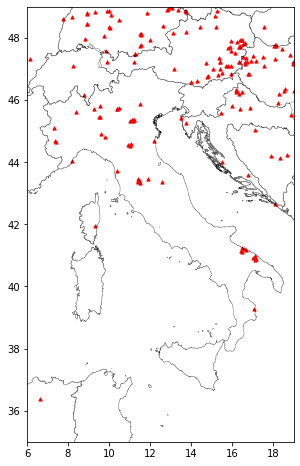

In [78]:
ax = filt_eswd_MISSED_2016.plot(markersize=10, figsize=(12, 8), marker='^', color='red',zorder=2)


ax.set_ylim(y_lim)
ax.set_xlim(x_lim)
#plt.autoscale(False)

#shapefiles    
for shp in sf_geo:
    shp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=3)

gpd.GeoDataFrame(filt_eswd_MISSED_2016['geometry_25km_box'], columns=['geometry_25km_box']).rename(columns={'geometry_25km_box' : 'geometry'}).plot(ax=ax, facecolor="none", edgecolor='grey');
gpd.GeoDataFrame(OTs_aroundMissed_eswd_2016['geometry']).plot(ax=ax,color='green')


In [79]:
filt_eswd_MISSED_2016

,datetime,lat,lon,size,QC_level,Time_accuracy,Max_hailst_weight,Thickness_hail_layer,Total_damage,N_injured,N_killed,Impacts,geometry
0,2016-04-06 15:55:00,46.993,13.150,NaN,QC0+,5M,NaN,2.0,NaN,NaN,NaN,NaN,POINT (13.15000 46.99300)
1,2016-04-07 06:30:00,45.815,9.571,NaN,QC1,30M,NaN,2.0,NaN,NaN,NaN,NaN,POINT (9.57100 45.81500)
2,2016-04-07 19:20:00,46.167,8.800,2.0,QC1,15M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (8.80000 46.16700)
3,2016-04-08 04:05:00,48.350,17.567,2.0,QC0+,5M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (17.56700 48.35000)
4,2016-04-08 14:30:00,45.117,7.308,NaN,QC1,30M,NaN,5.0,NaN,NaN,NaN,NaN,POINT (7.30800 45.11700)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2016-08-20 15:10:00,44.561,11.033,NaN,QC1,30M,NaN,NaN,NaN,NaN,NaN,NaN,POINT (11.03300 44.56100)
425,2016-09-01 15:28:00,48.183,13.750,2.5,QC0+,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (13.75000 48.18300)
432,2016-09-13 15:00:00,46.200,18.267,2.0,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (18.26700 46.20000)
434,2016-09-14 19:30:00,36.365,6.615,4.0,QC1,1H,NaN,NaN,NaN,NaN,NaN,NaN,POINT (6.61500 36.36500)


In [11]:
#Read dataframe from external file
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2016.txt', 'rb') as file:
     OTs_aroundMissed_eswd_2016 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2017.txt', 'rb') as file:
     OTs_aroundMissed_eswd_2017 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2018.txt', 'rb') as file:
     OTs_aroundMissed_eswd_2018 = pickle.load(file)

#### - Validation procedure to extract OT data around eswd

In [277]:
#define which set to consider for validation: filt_ or all_ 
OTset = OTset_dtmin_eswdHITTED_2018#all_OTset_2016_land
eswdSET = filt_eswd_HITTED_2018_Verylarge

In [278]:
eswd_HITTED = gpd.GeoDataFrame(columns=eswd.columns)
OTset_HITTING = gpd.GeoDataFrame(columns=OTset.columns)

#loop on OT detections
for OT_ind in OTset.index:
    
    OT = OTset[OTset.index == OT_ind]

    OTyear = int(OT.time.apply(lambda x: x.year))
    OTmonth = int(OT.time.apply(lambda x: x.month))
    OTday = int(OT.time.apply(lambda x: x.day))
    OThour = int(OT.time.apply(lambda x: x.hour))
    
    print(OT_ind)

    #select day before and above of OT timing
    OTtime_dAbove = pd.to_datetime(OT.time.item() + pd.to_timedelta(1, unit='d'))
    OTtime_dBefore = pd.to_datetime(OT.time.item() - pd.to_timedelta(1, unit='d'))
    OTtime_dAbove = OTtime_dAbove.replace(tzinfo=None)
    OTtime_dBefore = OTtime_dBefore.replace(tzinfo=None)

    #define eswd subset in the 3 days (before,present,and future) around OT timing: 
    #(this is done to make the loop more efficient!)
    """
    This step could be even more efficient by selecting directly only reports in a 1.5h temp window, for the moment
    lets try with +-1day and see if it is still too slow
    """
    eswd_subset = eswdSET[(eswdSET.datetime >= OTtime_dBefore) & (eswdSET.datetime <= OTtime_dAbove)]
    
    #loop on eswd reports
    for eswd_ind in eswd_subset.index:

        #calculate time delta between OT and eswd report:
        tdelta = pd.Timedelta(abs(OT.time.values[0] - eswd_subset.datetime[eswd_subset.index == eswd_ind].values[0]))
        
        #condition: if difference between OT and report timing is smaller than (+-)1.5h keep the report
        if tdelta <= timedelta(minutes=90):
            
            #condition on spatial neighbourhood: if eswd report falls inside OT box:
            if eswd_subset.geometry[eswd_ind].within(OTset.geometry_25km_box[OT_ind]):

                print('Hit!')
                eswd_HITTED = eswd_HITTED.append(eswd_subset[eswd_subset.index == eswd_ind])

                OTset_HITTING = OTset_HITTING.append(OTset[OTset.index == OT_ind])
    
"""
ALLA FINE DI TUTTO BISOGNA RIPULARE I DATASET HITTED E HITTING DAI DOPPIONI!
"""

4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4385
4386
4391
4392
4912
4913
4914
4915
4916
4917
4918
4919
4920
5897
5898
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5912
5913
5914
5915
5916
5917
5987
6288
6289
6292
6293
6295
6296
6298
6299
6300
6339
6340
6342
6343
6345
6346
9628
9629
9630
9631
9632
9633
9634
9635
9636
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9841
9842
9843
9844
9845
9846
9847
9852
9853
9854
9855
9856
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10177
10178
Hit!
10179
10180
10181
10182
10183
10206
10211
10212
10218
10219
10225
10226
10227
10228
10229
10238
10239
10240
10241
10242
10252
10253
10254
10255
10256
10270
10271
10272
10273
10274
10543
10544
10545
10546
10547
10548
10549
10550
10551
10553
10554
10555
10556
10557
10566
10567
10568
10572
10573
10574
10576
10578
10579
10580
10582
10583
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
Hit!
10656
Hit!
10657
Hit!
10658
Hit!
10659
Hit!
10660
10661
10662
10663
10664
10665
10

48369
48370
48371
48372
48373
48374
48375
48376
48377
48378
48522
48534
49191
49192
49193
49194
49196
49197
49497
49498
49499
49500
50507
50509
50510
50512
50513
51310
51311
51312
51313
51314
57577
57578
57579
57589
57820
Hit!
Hit!
57821
Hit!
Hit!
57822
Hit!
Hit!
57823
Hit!
Hit!
57824
Hit!
57825
Hit!
Hit!
57826
Hit!
Hit!
57827
Hit!
Hit!
57828
Hit!
57829
Hit!
Hit!
57830
Hit!
Hit!
57831
Hit!
Hit!
57832
Hit!
57833
57834
57835
57837
57838
57839
57843
57844
57845
57850
57861
58269
Hit!
Hit!
58270
Hit!
Hit!
58271
Hit!
Hit!
58272
Hit!
Hit!
58273
Hit!
Hit!
58277
Hit!
Hit!
58278
Hit!
Hit!
58279
Hit!
Hit!
58280
Hit!
Hit!
58283
Hit!
Hit!
58284
Hit!
Hit!
58285
Hit!
Hit!
58286
Hit!
Hit!
58287
Hit!
Hit!
58288
Hit!
Hit!
58289
Hit!
Hit!
58292
Hit!
Hit!
58293
Hit!
Hit!
58294
Hit!
Hit!
58297
58298
58299
58300
58301
58303
58304
58305
58306
58307
58313
58314
58315
58316
58323
58324
58901
Hit!
Hit!
58902
Hit!
Hit!
58903
Hit!
58908
Hit!
Hit!
58909
Hit!
Hit!
58910
Hit!
Hit!
58911
Hit!
Hit!
58912
Hit!
Hit!
58

98276
98277
98278
98279
98280
98334
98337
98338
98339
98340
98344
98345
98346
98347
98353
98354
98355
98356
98359
99819
99827
99828
99829
99830
99831
99837
99838
99839
99840
99841
99842
99843
99845
99846
99847
99848
99849
99851
100393
100394
100398
100399
100400
100401
100403
100404
100405
100934
100935
100936
100937
100938
100939
101084
Hit!
101085
Hit!
101086
Hit!
Hit!
101087
Hit!
Hit!
101088
Hit!
101089
Hit!
101093
Hit!
Hit!
101094
Hit!
Hit!
101095
Hit!
Hit!
101096
Hit!
101097
Hit!
101098
Hit!
101104
Hit!
101105
Hit!
Hit!
101106
Hit!
Hit!
101107
Hit!
Hit!
101108
Hit!
101109
Hit!
101110
Hit!
101112
Hit!
101113
Hit!
101114
Hit!
101115
Hit!
Hit!
Hit!
Hit!
101116
Hit!
Hit!
Hit!
Hit!
Hit!
101117
Hit!
101118
Hit!
101119
Hit!
Hit!
Hit!
Hit!
101120
Hit!
Hit!
Hit!
Hit!
Hit!
101299
101300
101303
101304
101305
101308
101393
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
101394
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
101395
Hit!
Hit!
Hit!
Hit!
Hit!
Hit!
101396
Hit!
101397
Hit!
101398
101399
101400
Hit!
101401
Hit!
101402

'\nALLA FINE DI TUTTO BISOGNA RIPULARE I DATASET HITTED E HITTING DAI DOPPIONI!\n'

In [279]:
#Clean HITTED and HITTING datasets from duplicates

#eswd: because the same eswd report can be detected in the vicinity of multiple OTs
eswd_HITTED_uniq = eswd_HITTED.drop_duplicates()

#OT: because the same OT can detect multiple eswd reports
OT_HITTING_uniq = OTset_HITTING[~OTset_HITTING.index.duplicated(keep='first')]

In [280]:
result_filt1_dict = dict()

result_filt1_dict['reports_HITTED'] = eswd_HITTED
result_filt1_dict['reports_HITTED_uniq'] = eswd_HITTED_uniq
result_filt1_dict['OTset_HITTING'] = OTset_HITTING
result_filt1_dict['OT_HITTING_uniq'] = OT_HITTING_uniq

In [281]:
len(eswd_HITTED_uniq)

41

In [282]:
len(eswdSET)

41

In [283]:
#write dictionary to external file
#with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/VerylargeHail/2018.txt', 'wb') as file:
#     pickle.dump(result_filt1_dict,file)

### - Dtmin, Irbmin distributions for HITTED eswd reports with OTfilter

In [34]:
#UPLOAD OT DATA AFTER IDENTIFICATION OF DTMIN/IRBMIN FOR HITTED ESWD REPORTS:

#ALL HITTED REPORTS
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/allReports/2016.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2016 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/allReports/2017.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2017 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/allReports/2018.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2018 = pickle.load(file)
        
#SMALL-HAIL HITTED REPORTS
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/smallHail/2016.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2016_small = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/smallHail/2017.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2017_small = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/smallHail/2018.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2018_small = pickle.load(file)
        
#LARGE-HAIL HITTED REPORTS
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/largeHail/2016.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2016_large = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/largeHail/2017.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2017_large = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/largeHail/2018.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2018_large = pickle.load(file)
        
#VERY-LARGE-HAIL HITTED REPORTS
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/VerylargeHail/2016.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2016_Verylarge = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/VerylargeHail/2017.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2017_Verylarge = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/HITTEDeswd/VerylargeHail/2018.txt', 'rb') as file:
     ESWDOTset_dtmin_eswdHITTED_2018_Verylarge = pickle.load(file)

In [35]:
#FILTERED OTs HITTED ESWD REPORTS:

#ALL
OTset_dtmin_eswdHITTED_2016 = ESWDOTset_dtmin_eswdHITTED_2016['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2017 = ESWDOTset_dtmin_eswdHITTED_2017['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2018 = ESWDOTset_dtmin_eswdHITTED_2018['OT_HITTING_uniq']

OTset_dtmin_eswdHITTED_2016_2018 = pd.concat([OTset_dtmin_eswdHITTED_2016,OTset_dtmin_eswdHITTED_2017,
                                              OTset_dtmin_eswdHITTED_2018])

#SMALL-HAIL
OTset_dtmin_eswdHITTED_2016_small = ESWDOTset_dtmin_eswdHITTED_2016_small['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2017_small = ESWDOTset_dtmin_eswdHITTED_2017_small['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2018_small = ESWDOTset_dtmin_eswdHITTED_2018_small['OT_HITTING_uniq']

OTset_dtmin_eswdHITTED_2016_2018_small = pd.concat([OTset_dtmin_eswdHITTED_2016_small,
                                                    OTset_dtmin_eswdHITTED_2017_small,
                                                    OTset_dtmin_eswdHITTED_2018_small])

#LARGE-HAIL
OTset_dtmin_eswdHITTED_2016_large = ESWDOTset_dtmin_eswdHITTED_2016_large['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2017_large = ESWDOTset_dtmin_eswdHITTED_2017_large['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2018_large = ESWDOTset_dtmin_eswdHITTED_2018_large['OT_HITTING_uniq']

OTset_dtmin_eswdHITTED_2016_2018_large = pd.concat([OTset_dtmin_eswdHITTED_2016_large,
                                                    OTset_dtmin_eswdHITTED_2017_large,
                                                    OTset_dtmin_eswdHITTED_2018_large])

#VERY-LARGE-HAIL
OTset_dtmin_eswdHITTED_2016_Verylarge = ESWDOTset_dtmin_eswdHITTED_2016_Verylarge['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2017_Verylarge = ESWDOTset_dtmin_eswdHITTED_2017_Verylarge['OT_HITTING_uniq']
OTset_dtmin_eswdHITTED_2018_Verylarge = ESWDOTset_dtmin_eswdHITTED_2018_Verylarge['OT_HITTING_uniq']

OTset_dtmin_eswdHITTED_2016_2018_Verylarge = pd.concat([OTset_dtmin_eswdHITTED_2016_Verylarge,
                                                    OTset_dtmin_eswdHITTED_2017_Verylarge,
                                                    OTset_dtmin_eswdHITTED_2018_Verylarge])

Some statistics:

- A total of 8396 OTs over 2016-2018 are detected (with otpmax>0.5) around the set of HITTED eswd events by OTfilt
- The 6% (452/8396) are associated with reports without info on hail size
- The 32% (2661/8396) are associated with small hail (<3cm)
- The 63% (5283(8396) are associated wtih large hail (>=3cm)
- While the 22% (1820/8396) are associated with very large hail (>=5cm)

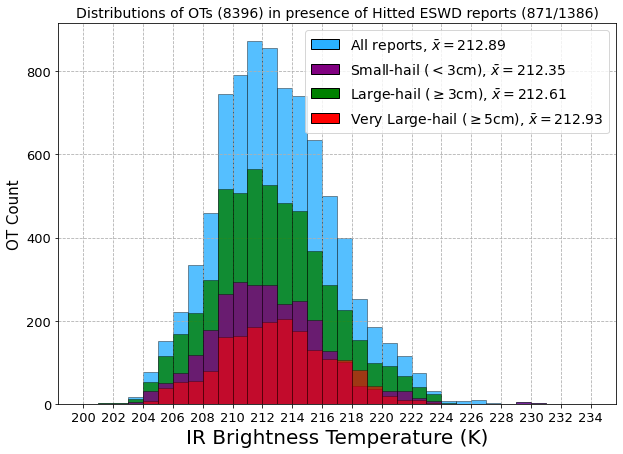

In [175]:
plt.figure(figsize=(10,7)) 

plt.hist(OTset_dtmin_eswdHITTED_2016_2018['irbmin'], bins=np.arange(200,235,1),
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5, alpha=0.8)
plt.hist(OTset_dtmin_eswdHITTED_2016_2018_small['irbmin'], bins=np.arange(200,235,1),
         facecolor = 'purple', edgecolor='black', linewidth=0.5, zorder=3, alpha=0.8)
plt.hist(OTset_dtmin_eswdHITTED_2016_2018_large['irbmin'], bins=np.arange(200,235,1),
         facecolor = 'green', edgecolor='black', linewidth=0.5, zorder=2, alpha=0.8)
plt.hist(OTset_dtmin_eswdHITTED_2016_2018_Verylarge['irbmin'], bins=np.arange(200,235,1),
         facecolor = 'red', edgecolor='black', linewidth=0.5, zorder=4, alpha=0.6)
pl.locator_params(axis='x', nbins=25)

plt.xlabel('IR Brightness Temperature (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = 212.89$",r"Small-hail ($<3$cm), $\bar{x} = 212.35$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = 212.61$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = 212.93$"]
plt.ylabel('OT Count',fontsize=15)
plt.title('Distributions of OTs (8396) in presence of Hitted ESWD reports (871/1386)', fontsize=14)

plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/irbminHist_HittedESWDFilt_smallLarge.png', 
            dpi=300, bbox_inches='tight')

In [255]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018['irbmin'])

212.88578833097955

In [256]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018_small['irbmin'])

212.3516599532582

In [257]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018_large['irbmin'])

212.60698726667772

In [289]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018_Verylarge['irbmin'])

212.9336762732202

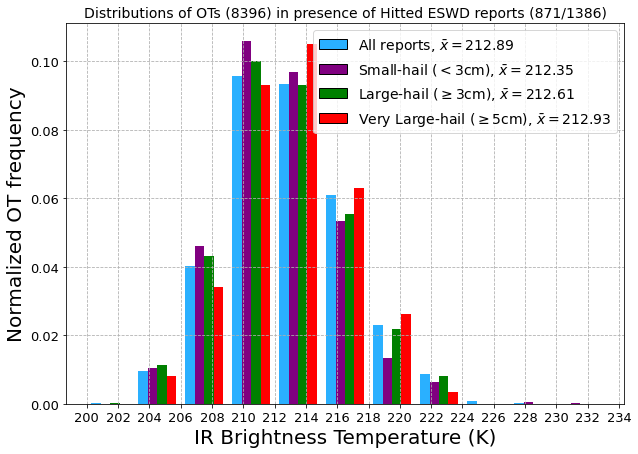

In [174]:
plt.figure(figsize=(10,7)) 

plt.hist([OTset_dtmin_eswdHITTED_2016_2018['irbmin'], OTset_dtmin_eswdHITTED_2016_2018_small['irbmin'],
          OTset_dtmin_eswdHITTED_2016_2018_large['irbmin'],  OTset_dtmin_eswdHITTED_2016_2018_Verylarge['irbmin']], 
         bins=np.arange(200,235,3), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','green','red'])

pl.locator_params(axis='x', nbins=25)

plt.xlabel('IR Brightness Temperature (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = 212.89$",r"Small-hail ($<3$cm), $\bar{x} = 212.35$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = 212.61$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = 212.93$"]
plt.ylabel('Normalized OT frequency', fontsize=20)
plt.title('Distributions of OTs (8396) in presence of Hitted ESWD reports (871/1386)', fontsize=14)

plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/irbminHist_HittedESWDFilt_smallLarge_Normalized.png', 
            dpi=300, bbox_inches='tight')

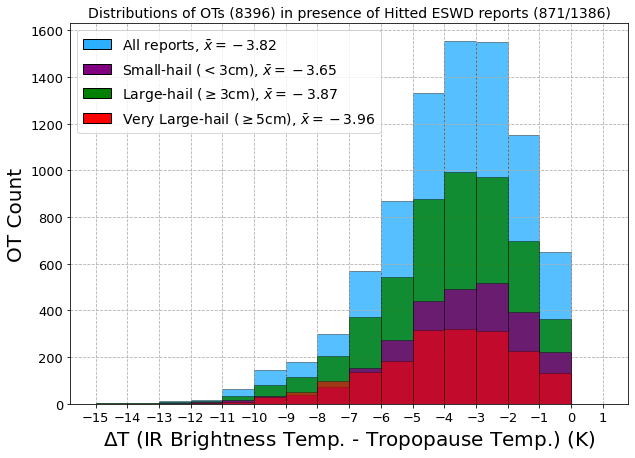

In [168]:
plt.figure(figsize=(10,7)) 

plt.hist(OTset_dtmin_eswdHITTED_2016_2018['dtmin'], bins=np.arange(-15,2,1),
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5, alpha=0.8)
plt.hist(OTset_dtmin_eswdHITTED_2016_2018_small['dtmin'], bins=np.arange(-15,2,1),
         facecolor = 'purple', edgecolor='black', linewidth=0.5, zorder=3, alpha=0.8)
plt.hist(OTset_dtmin_eswdHITTED_2016_2018_large['dtmin'], bins=np.arange(-15,2,1),
         facecolor = 'green', edgecolor='black', linewidth=0.5, zorder=2, alpha=0.8)
plt.hist(OTset_dtmin_eswdHITTED_2016_2018_Verylarge['dtmin'], bins=np.arange(-15,2,1),
         facecolor = 'red', edgecolor='black', linewidth=0.5, zorder=4, alpha=0.6)

pl.locator_params(axis='x', nbins=25)

plt.ylabel('OT Count', fontsize=20)
plt.xlabel(r'$\Delta$T (IR Brightness Temp. - Tropopause Temp.) (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = -3.82$",r"Small-hail ($<3$cm), $\bar{x} = -3.65$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = -3.87$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = -3.96$"]
plt.title('Distributions of OTs (8396) in presence of Hitted ESWD reports (871/1386)', fontsize=14)

plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/dtminHist_HittedESWDFilt_smallLarge.png', 
            dpi=300, bbox_inches='tight')

In [252]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018['dtmin'])

-3.8210469936972404

In [253]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018_small['dtmin'])

-3.645174596328477

In [254]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018_large['dtmin'])

-3.8740547291374603

In [293]:
np.mean(OTset_dtmin_eswdHITTED_2016_2018_Verylarge['dtmin'])

-3.958582767025455

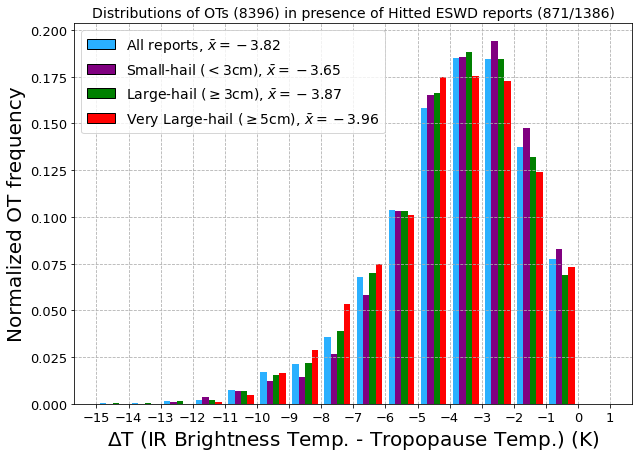

In [173]:
plt.figure(figsize=(10,7)) 

plt.hist([OTset_dtmin_eswdHITTED_2016_2018['dtmin'], OTset_dtmin_eswdHITTED_2016_2018_small['dtmin'],
          OTset_dtmin_eswdHITTED_2016_2018_large['dtmin'],  OTset_dtmin_eswdHITTED_2016_2018_Verylarge['dtmin']], 
         bins=np.arange(-15,2,1), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','green','red'])

pl.locator_params(axis='x', nbins=25)

plt.ylabel('Normalized OT frequency', fontsize=20)
plt.xlabel(r'$\Delta$T (IR Brightness Temp. - Tropopause Temp.) (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = -3.82$",r"Small-hail ($<3$cm), $\bar{x} = -3.65$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = -3.87$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = -3.96$"]
plt.title('Distributions of OTs (8396) in presence of Hitted ESWD reports (871/1386)', fontsize=14)

plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/dtminHist_HittedESWDFilt_smallLarge_Normalized.png', 
            dpi=300, bbox_inches='tight')

### - Dtmin, Irbmin distributions for MISSED eswd reports with OTfilter

In [11]:
#Upload OTs in presence of MISSED eswd reports from external file
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2016.txt', 'rb') as file:
     OTset_dtmin_eswdMISSED_2016 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2017.txt', 'rb') as file:
     OTset_dtmin_eswdMISSED_2017 = pickle.load(file)
with open(fold + 'data/OTfilter_validation/Irbmin_dtmin/MISSEDeswd/2018.txt', 'rb') as file:
     OTset_dtmin_eswdMISSED_2018 = pickle.load(file)

In [12]:
#ALL
OTset_dtmin_eswdMISSED_2016_2018 = pd.concat([OTset_dtmin_eswdMISSED_2016,OTset_dtmin_eswdMISSED_2017,
                                             OTset_dtmin_eswdMISSED_2018])

#SMALL HAIL (<3cm)
OTset_dtmin_eswdMISSED_2016_2018_small = OTset_dtmin_eswdMISSED_2016_2018[
    OTset_dtmin_eswdMISSED_2016_2018['hail_size'] < 3]

#LARGE HAIL (>=3cm)
OTset_dtmin_eswdMISSED_2016_2018_large = OTset_dtmin_eswdMISSED_2016_2018[
    OTset_dtmin_eswdMISSED_2016_2018['hail_size'] >= 3]

#VERY LARGE HAIL (>=5cm)
OTset_dtmin_eswdMISSED_2016_2018_Verylarge = OTset_dtmin_eswdMISSED_2016_2018[
    OTset_dtmin_eswdMISSED_2016_2018['hail_size'] >= 5]

Some statistics:

- A total of 61170 OTs over 2016-2018 are detected around the set of MISSED eswd events (number much larger than for the HITTED set because there is no constraint on otpmax threshold, so all OT data are retained!)
- The 31% (18791/61170) are associated with reports without info on hail size
- The 34% (20974/61170) are associated with small hail (<3cm)
- The 35% (21405/61170) are associated wtih large hail (>=3cm)
- While the 6% (3708/61170) are associated with very large hail (>=5cm)

- Furthermore, the number of OTs having info on dtmin is lower than all those having info on irbmin (probably because in some occasions it was not possible to calculate dtmin?), so the statistic sample for the dtmin statistics is a little reduced

- The 80% (29798/37116) of Dtmin data are >=0K (indicating a tropopause temperature warmer than IR brightness temperature, i.e. a non-detection of OT with the algorithm)

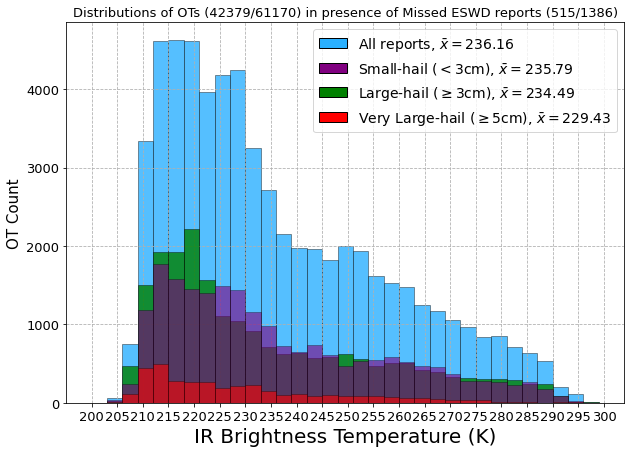

In [172]:
plt.figure(figsize=(10,7)) 

plt.hist(OTset_dtmin_eswdMISSED_2016_2018['irbmin'], bins=np.arange(200,300,3),
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5, alpha=0.8)
plt.hist(OTset_dtmin_eswdMISSED_2016_2018_small['irbmin'], bins=np.arange(200,300,3),
         facecolor = 'purple', edgecolor='black', linewidth=0.5, zorder=3, alpha=0.6)
plt.hist(OTset_dtmin_eswdMISSED_2016_2018_large['irbmin'], bins=np.arange(200,300,3),
         facecolor = 'green', edgecolor='black', linewidth=0.5, zorder=2, alpha=0.8)
plt.hist(OTset_dtmin_eswdMISSED_2016_2018_Verylarge['irbmin'], bins=np.arange(200,300,3),
         facecolor = 'red', edgecolor='black', linewidth=0.5, zorder=4, alpha=0.6)
pl.locator_params(axis='x', nbins=26)

plt.xlabel('IR Brightness Temperature (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = 236.16$",r"Small-hail ($<3$cm), $\bar{x} = 235.79$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = 234.49$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = 229.43$"]
plt.ylabel('OT Count', fontsize=15)
plt.title('Distributions of OTs (42379/61170) in presence of Missed ESWD reports (515/1386)', fontsize=13)

plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/irbminHist_MissedESWDFilt_smallLarge.png', 
            dpi=300, bbox_inches='tight')

In [77]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018['irbmin'])

236.15642335950034

In [102]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018_small['irbmin'])

235.78567505828576

In [104]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018_large['irbmin'])

234.48758413612885

In [105]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018_Verylarge['irbmin'])

229.431977046732

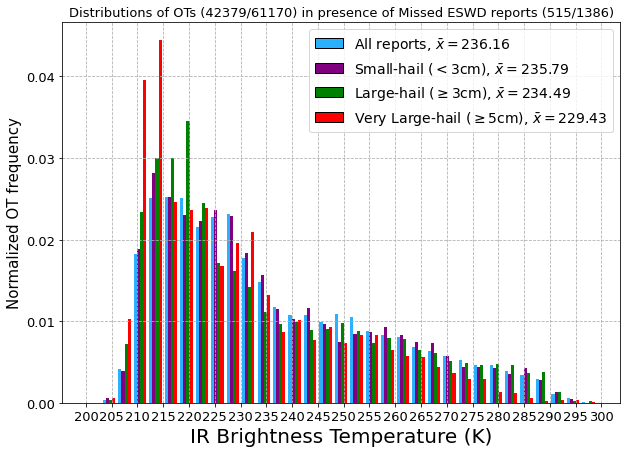

In [171]:
plt.figure(figsize=(10,7)) 

plt.hist([OTset_dtmin_eswdMISSED_2016_2018['irbmin'], OTset_dtmin_eswdMISSED_2016_2018_small['irbmin'],
          OTset_dtmin_eswdMISSED_2016_2018_large['irbmin'],  OTset_dtmin_eswdMISSED_2016_2018_Verylarge['irbmin']], 
         bins=np.arange(200,300,3), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','green','red'])

pl.locator_params(axis='x', nbins=26)

plt.xlabel('IR Brightness Temperature (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = 236.16$",r"Small-hail ($<3$cm), $\bar{x} = 235.79$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = 234.49$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = 229.43$"]
plt.ylabel('Normalized OT frequency',fontsize=15)
plt.title('Distributions of OTs (42379/61170) in presence of Missed ESWD reports (515/1386)', fontsize=13)

plt.legend(handles, labels, fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/irbminHist_MissedESWDFilt_smallLarge_Normalized.png', 
            dpi=300, bbox_inches='tight')

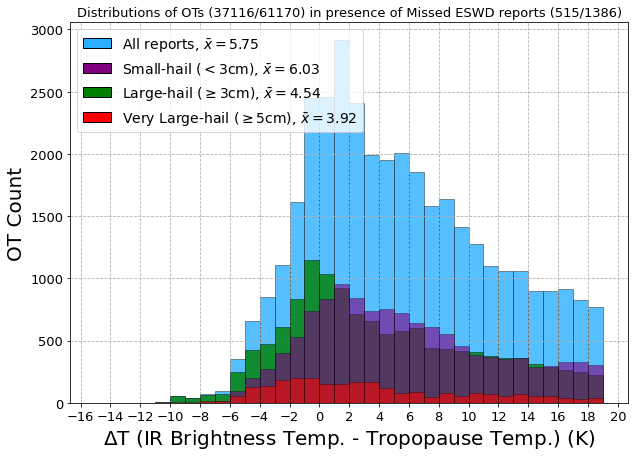

In [169]:
plt.figure(figsize=(10,7)) 

plt.hist(OTset_dtmin_eswdMISSED_2016_2018['dtmin'], bins=np.arange(-15,20,1),
         facecolor = '#2ab0ff', edgecolor='black', linewidth=0.5, alpha=0.8)
plt.hist(OTset_dtmin_eswdMISSED_2016_2018_small['dtmin'], bins=np.arange(-15,20,1),
         facecolor = 'purple', edgecolor='black', linewidth=0.5, zorder=3, alpha=0.6)
plt.hist(OTset_dtmin_eswdMISSED_2016_2018_large['dtmin'], bins=np.arange(-15,20,1),
         facecolor = 'green', edgecolor='black', linewidth=0.5, zorder=2, alpha=0.8)
plt.hist(OTset_dtmin_eswdMISSED_2016_2018_Verylarge['dtmin'], bins=np.arange(-15,20,1),
         facecolor = 'red', edgecolor='black', linewidth=0.5, zorder=4, alpha=0.6)

pl.locator_params(axis='x', nbins=25)

plt.ylabel('OT Count', fontsize=20)
plt.xlabel(r'$\Delta$T (IR Brightness Temp. - Tropopause Temp.) (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = 5.75$",r"Small-hail ($<3$cm), $\bar{x} = 6.03$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = 4.54$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = 3.92$"]
plt.title('Distributions of OTs (37116/61170) in presence of Missed ESWD reports (515/1386)', fontsize=13)

plt.legend(handles, labels, fontsize=14, loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/dtminHist_MissedESWDFilt_smallLarge.png', 
            dpi=300, bbox_inches='tight')

In [133]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018['dtmin'])

5.75051428976469

In [134]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018_small['dtmin'])

6.025390688728591

In [135]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018_large['dtmin'])

4.544307092364416

In [136]:
np.mean(OTset_dtmin_eswdMISSED_2016_2018_Verylarge['dtmin'])

3.915917304867029

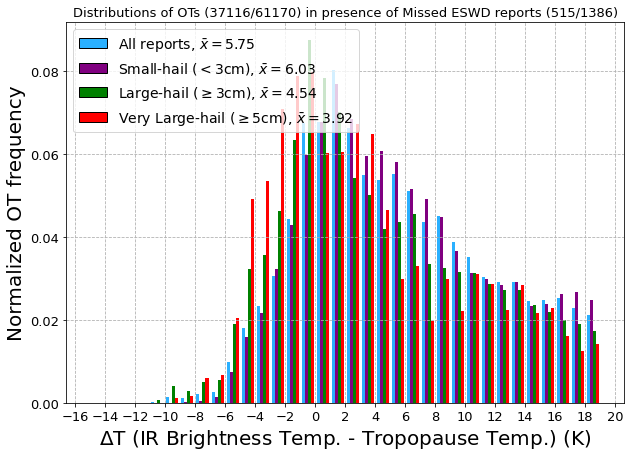

In [13]:
plt.figure(figsize=(10,7)) 

plt.hist([OTset_dtmin_eswdMISSED_2016_2018['dtmin'], OTset_dtmin_eswdMISSED_2016_2018_small['dtmin'],
          OTset_dtmin_eswdMISSED_2016_2018_large['dtmin'],  OTset_dtmin_eswdMISSED_2016_2018_Verylarge['dtmin']], 
         bins=np.arange(-15,20,1), density=True, label=['All', 'Small','Large','Very large'],
        color=['#2ab0ff','purple','green','red'])

pl.locator_params(axis='x', nbins=20)

plt.ylabel('Normalized OT frequency', fontsize=20)
plt.xlabel(r'$\Delta$T (IR Brightness Temp. - Tropopause Temp.) (K)', fontsize=20)

handles = [Rectangle((0,0),1,1, color=c, ec="k") for c in ['#2ab0ff','purple','green','red']]
labels= [r"All reports, $\bar{x} = 5.75$",r"Small-hail ($<3$cm), $\bar{x} = 6.03$",
         r"Large-hail ($\geq 3$cm), $\bar{x} = 4.54$",r"Very Large-hail ($\geq 5$cm), $\bar{x} = 3.92$"]
plt.title('Distributions of OTs (37116/61170) in presence of Missed ESWD reports (515/1386)', fontsize=13)

plt.legend(handles, labels, fontsize=14, loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(ls='--')

plt.savefig(f'/home/ciccuz/phd/KIT/scripts/plots/OT_filter_validation/irbmin_dtmin/dtminHist_MissedESWDFilt_smallLarge_Normalized.pdf', 
            dpi=300, bbox_inches='tight')

The tail of distributions after 20K are cut out due to condition in function processing OT data (HF.HF_OTdata)

In [180]:
OTset_dtmin_eswdMISSED_2016_2018[OTset_dtmin_eswdMISSED_2016_2018['dtmin']>=0]

lon        lat                       time  otpmax      dtmin  \
xlon xlat                                                                       
49   199   13.060000  47.097145  2016-04-06 15:00:00+00:00     NaN   4.400009   
     200   13.095715  47.097145  2016-04-06 15:00:00+00:00     NaN   4.100006   
     201   13.131429  47.096142  2016-04-06 15:00:00+00:00     NaN   3.540009   
     202   13.166142  47.096142  2016-04-06 15:00:00+00:00     NaN   3.540009   
     203   13.201857  47.096142  2016-04-06 15:00:00+00:00     NaN   4.100006   
...              ...        ...                        ...     ...        ...   
189  187   12.653428  42.139145       2018-10-21T17:00:00Z     NaN  16.900009   
191  185   12.582000  42.065716       2018-10-21T17:00:00Z     NaN  15.919998   
     186   12.616714  42.065716       2018-10-21T17:00:00Z     NaN  15.389999   
     187   12.653428  42.066715       2018-10-21T17:00:00Z     NaN  16.279999   
192  181   12.439142  42.029999       2018-10-21T17:00:00Z     NaN  17.120010   

               irbmin                   geometry  hail_size  
xlon xlat                                                    
49   199   216.970001  POINT (13.06000 47.09715)        NaN  
     200   216.639999  POINT (13.09571 47.09715)        NaN  
     201   216.110001  POINT (13.13143 47.09614)        NaN  
     202   216.089996  POINT (13.16614 47.09614)        NaN  
     203   216.619995  POINT (13.20186 47.09614)        NaN  
...               ...                        ...        ...  
189  187   240.970001  POINT (12.65343 42.13914)        3.0  
191  185   239.449997  POINT (12.58200 42.06572)        3.0  
     186   238.949997  POINT (12.61671 42.06572)        3.0  
     187   239.869995  POINT (12.65343 42.06672)        3.0  
192  181   240.639999  POINT (12.43914 42.03000)        3.0  

[29823 rows x 8 columns]

In [186]:
OTset_dtmin_eswdMISSED_2016_2018_Verylarge[OTset_dtmin_eswdMISSED_2016_2018_Verylarge['dtmin']>=3.92]

lon        lat                       time  otpmax      dtmin  \
xlon xlat                                                                       
114  176   12.254572  44.794712  2016-06-14 07:00:00+00:00     NaN  13.990005   
     177   12.290286  44.793713  2016-06-14 07:00:00+00:00     NaN   9.450012   
     176   12.254572  44.793713  2016-06-14 08:00:00+00:00     NaN  11.899994   
     177   12.289286  44.791714  2016-06-14 08:00:00+00:00     NaN   5.279999   
115  176   12.256572  44.763000  2016-06-14 08:00:00+00:00     NaN  19.669998   
...              ...        ...                        ...     ...        ...   
179  230   14.180143  42.486286       2018-09-02T16:00:00Z     NaN  12.889999   
180  225   14.002571  42.451569       2018-09-02T16:00:00Z     NaN  16.000000   
     226   14.038285  42.451569       2018-09-02T16:00:00Z     NaN  16.079987   
     228   14.109715  42.452568       2018-09-02T16:00:00Z     NaN  17.509995   
     229   14.145430  42.452568       2018-09-02T16:00:00Z     NaN  17.160004   

               irbmin                   geometry  hail_size  
xlon xlat                                                    
114  176   235.509995  POINT (12.25457 44.79471)        5.0  
     177   230.940002  POINT (12.29029 44.79371)        5.0  
     176   233.439987  POINT (12.25457 44.79371)        5.0  
     177   226.789993  POINT (12.28929 44.79171)        5.0  
115  176   241.250000  POINT (12.25657 44.76300)        5.0  
...               ...                        ...        ...  
179  230   236.189987  POINT (14.18014 42.48629)        8.0  
180  225   239.339996  POINT (14.00257 42.45157)        8.0  
     226   239.409988  POINT (14.03829 42.45157)        8.0  
     228   240.819992  POINT (14.10971 42.45257)        8.0  
     229   240.470001  POINT (14.14543 42.45257)        8.0  

[1046 rows x 8 columns]

In [183]:
OTset_dtmin_eswdMISSED_2016_2018_Verylarge

lon        lat                       time  otpmax      dtmin  \
xlon xlat                                                                       
114  171   12.078000  44.795712  2016-06-14 07:00:00+00:00     NaN        NaN   
     172   12.112714  44.795712  2016-06-14 07:00:00+00:00     NaN        NaN   
     174   12.189143  44.806713  2016-06-14 07:00:00+00:00     NaN        NaN   
     175   12.222857  44.803715  2016-06-14 07:00:00+00:00     NaN        NaN   
     176   12.254572  44.794712  2016-06-14 07:00:00+00:00     NaN  13.990005   
...              ...        ...                        ...     ...        ...   
180  226   14.038285  42.451569       2018-09-02T16:00:00Z     NaN  16.079987   
     227   14.076000  42.456570       2018-09-02T16:00:00Z     NaN        NaN   
     228   14.109715  42.452568       2018-09-02T16:00:00Z     NaN  17.509995   
     229   14.145430  42.452568       2018-09-02T16:00:00Z     NaN  17.160004   
     230   14.183144  42.457569       2018-09-02T16:00:00Z     NaN        NaN   

               irbmin                   geometry  hail_size  
xlon xlat                                                    
114  171   275.089996  POINT (12.07800 44.79571)        5.0  
     172   265.470001  POINT (12.11271 44.79571)        5.0  
     174   249.099991  POINT (12.18914 44.80671)        5.0  
     175   245.949997  POINT (12.22286 44.80371)        5.0  
     176   235.509995  POINT (12.25457 44.79471)        5.0  
...               ...                        ...        ...  
180  226   239.409988  POINT (14.03829 42.45157)        8.0  
     227   246.989990  POINT (14.07600 42.45657)        8.0  
     228   240.819992  POINT (14.10971 42.45257)        8.0  
     229   240.470001  POINT (14.14543 42.45257)        8.0  
     230   247.750000  POINT (14.18314 42.45757)        8.0  

[3708 rows x 8 columns]

In [187]:
1046/3708

0.2820927723840345

In [181]:
29798/37116

0.8028343571505551